<font color = 'red'> <b>Introduction</b></font>

Previously we trained a churn prediction model and we evaluated it. this week we take the model and deploy it on web service. since this model stays in the jupyter notebook

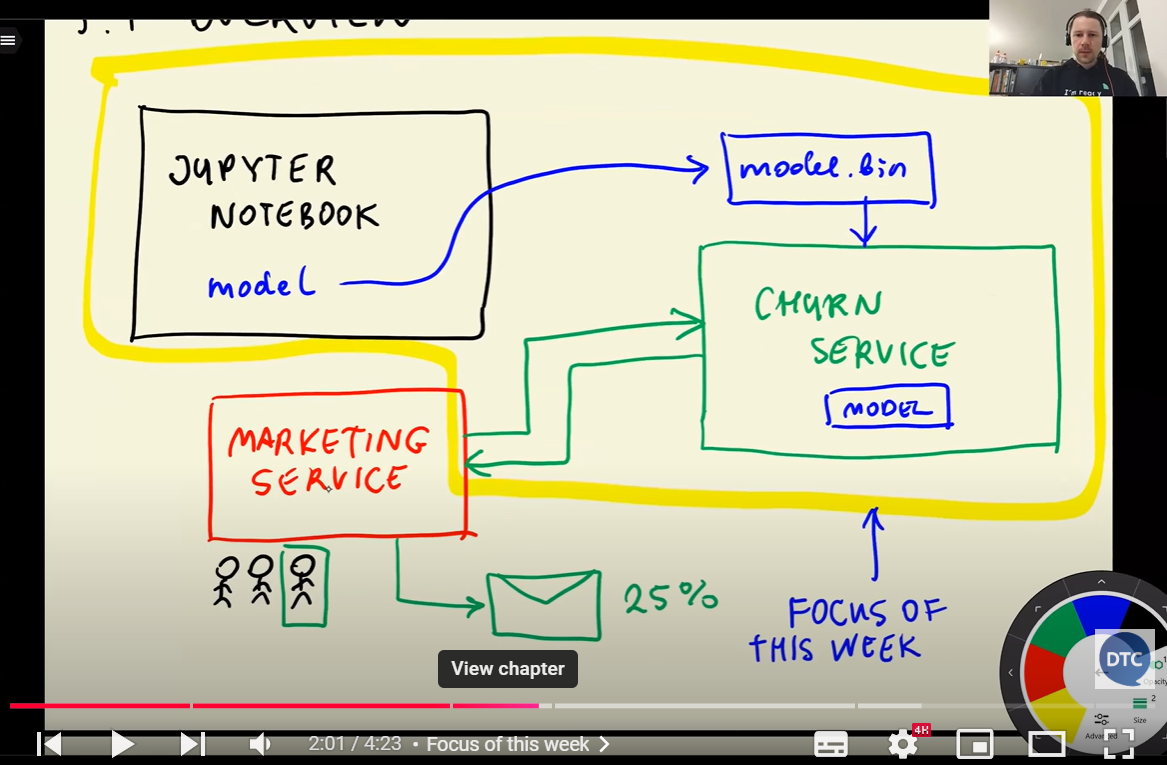

In [11]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score



In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')
    
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn =='yes').astype(int)

In [13]:
df_full_train,df_test = train_test_split(df, test_size = 0.2,random_state=1)

In [14]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [15]:
def train(df_train,y_train,C=1.0):     # C is the regualrization parameter for the logistic regression just like there was one in the linear regression
    dicts = df_train[categorical+numerical].to_dict(orient='records')
    
    dv=DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C,max_iter=1000)
    model.fit(X_train,y_train)
    
    return dv,model

In [16]:
def Predict(df,dv,model):
    dicts = df[categorical+numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [17]:
C=1.0
n_splits = 5

In [18]:
kfold = KFold(n_splits=n_splits, shuffle = True,random_state=1)

scores = []

for train_idx,val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv,model = train(df_train,y_train,C=C)
    y_pred = Predict(df_val,dv,model)
    
    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)
    
print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

C=1.0 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
scores

[np.float64(0.8446632807655171),
 np.float64(0.8452295225797907),
 np.float64(0.833257074051776),
 np.float64(0.8346889588795804),
 np.float64(0.8517617897147877)]

In [20]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = Predict(df_test, dv, model)

y_test = df_test.churn.values
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8584005005037537)

Now the task will be to save our model and then put this inside web service for that we will use <font color = 'orange'>FLASK</font> that is a framework for creating web services in python.Then we want to isoltate the dependencies for this service in a way that this does not interfere with the other services that we have on out machine so we will create a special environment for python dependencies for this we will use <font color = 'orange'>PIPENV</font>. Then we will add another layer and this layer will be for system dependencies using <font color = 'orange'>DOCKER</font>. After all that we will deploy it on cloud. so we will take the container and deploy it on the <font color = 'orange'>AWS elastic beanstalk</font><br>
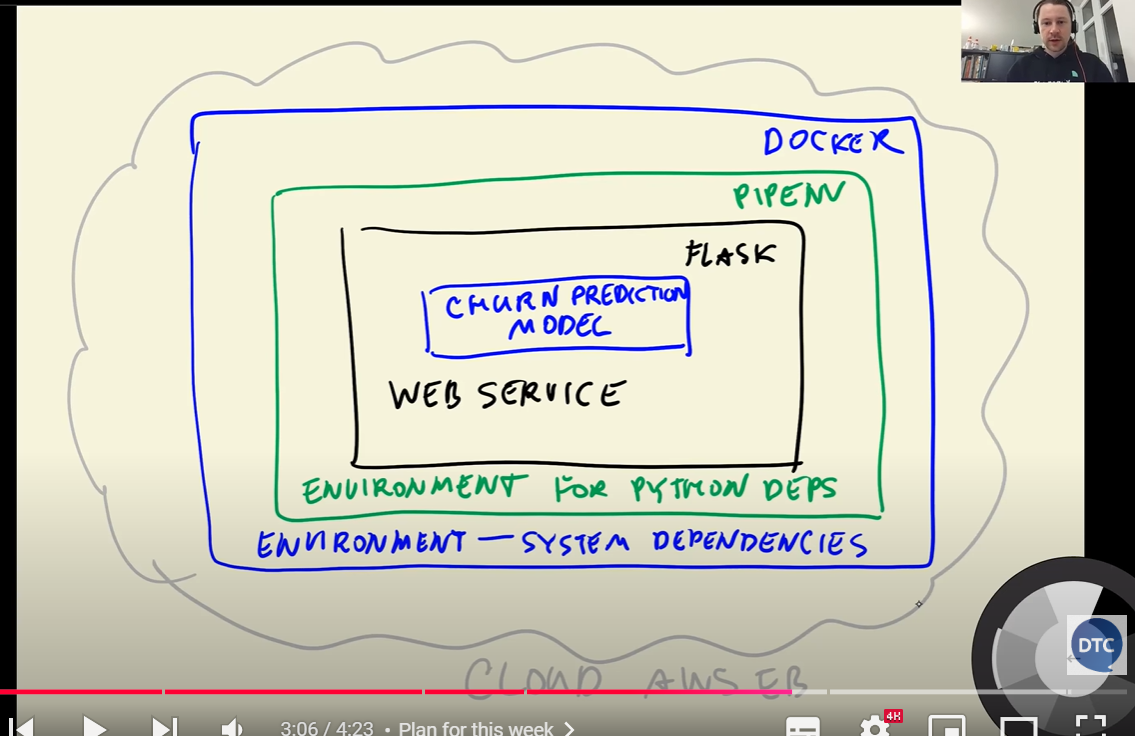

<b><font color ='red'><h4>Saving and loading the model</h4></font></b><br>

for saving the model we will use <font color = 'orange'>Pickle</font> that is a built in library for saving python objects

Save the model

In [21]:
import pickle

In [23]:
# Lets create a file where we will write the model.C
output_file = f'model_C={C}.bin' # this is how the name of our file will look like
output_file

'model_C=1.0.bin'

In [ ]:
f_out = open(output_file,'wb') # Open opens the file and w refers to that we are going to write tot hte file and b refers to that bytes to that file
pickle.dump((dv,model),f_out) #we use dump function to write the file
f_out.close() # closing the file it is very important.


In [27]:
# sometimes we forget to close the file hence we can use the "with" that automatically closes the file

with open(output_file,'wb') as f_out:
    pickle.dump((dv,model),f_out)
    # do stuff 
    # till here as well the file is open
    
#do other stuff-- here the file is closed

Load the model - restart the model and load the model. Restarting makes sure this is new.